# Generator-level study

This notebook allows to better understand the topology of exclusive SUSY events, and the various kinematic variables of interest to be used later in this project.
We are starting from the NanoAOD level samples produced, either centrally (most of inclusive background samples) or privately (exclusive, or semi-exclusive background and signal samples). A first filtering is required before starting to plot these few distributions.

Authors: C. Caillol, L. Forthomme, P. Silva

First, let us start with a bit of prerequisite imports.

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import ROOT
import PyRDF
sys.path.append('../Utils')
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.lumi_sqrtS = "13 TeV"
CMS_lumi.extraText = "Simulation"

from samples import excl_susy_samples_mu as samples

#FIXME r/w accessible folder must be given
OUTPUT_DIR = '/eos/user/l/lforthom/studies/exclusive_susy/data'
CHUNKS_DIR = OUTPUT_DIR + '/Chunks' # location for intermediate "chunk" files
if not os.path.exists(CHUNKS_DIR):
    os.mkdir(CHUNKS_DIR)

Welcome to JupyROOT 6.24/06


## First stage of the selection

This first stage preselects events which contain at least a pair of leptons of interest.

In [2]:
# either run locally with this SWAN kernel, or use a Spark distributed computation (/!| careful as multiple output chunks files may be created)
local = True
for smp in samples:
    print('Processing {} with {} file(s)'.format(smp.short, len(smp.files)))
    if local:
        ROOT.ROOT.EnableImplicitMT()
        PyRDF.use('local')
        files = ['root://cms-xrd-global.cern.ch/{}'.format(f) for f in smp.files]
    else:
        PyRDF.use('spark', {'npartitions': 20})
        #files = ['root://eosuser.cern.ch/{}'.format(f) for f in smp.files]
        files = ['root://cms-xrd-global.cern.ch/{}'.format(f) for f in smp.files]
    PyRDF.include_headers('NanoAODHelpers.h')
    
    # define the selections and branches with an RDataFrame
    rdf = PyRDF.RDataFrame("Events", files)
    
    # generator-level selection of all relevant particles
    rdf = rdf.Define('gen_prot', 'protonsFromEventContent(GenPart_pdgId, GenPart_status, GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass)') \
             .Define('prot_pt', 'lorentzVector_pt(gen_prot)') \
             .Define('prot_eta', 'lorentzVector_eta(gen_prot)') \
             .Define('prot_phi', 'lorentzVector_phi(gen_prot)') \
             .Define('prot_px', 'lorentzVector_px(gen_prot)') \
             .Define('prot_py', 'lorentzVector_py(gen_prot)') \
             .Define('prot_pz', 'lorentzVector_pz(gen_prot)') \
             .Define('prot_en', 'lorentzVector_energy(gen_prot)') \
             .Define('gen_sel', 'stableParticle(GenPart_pdgId, GenPart_status)') \
             .Define('gen_lep', 'gen_sel && chargedLepton(GenPart_pdgId, GenPart_status)') \
             .Define('gen_slep', 'chargedSlepton(GenPart_pdgId, GenPart_status)') \
             .Define('gen_neu', 'neutralino(GenPart_pdgId, GenPart_status)') \
             .Define('GenPart_px', 'GenPart_pt*ROOT::VecOps::cos(GenPart_phi)' ) \
             .Define('GenPart_py', 'GenPart_pt*ROOT::VecOps::sin(GenPart_phi)' ) \
             .Define('GenPart_pz', 'GenPart_pt*ROOT::VecOps::sinh(GenPart_eta)' ) \
             .Define('GenPart_en', 'ROOT::VecOps::sqrt(GenPart_mass*GenPart_mass+GenPart_pt*GenPart_pt+GenPart_pz*GenPart_pz)' )

    # missing transverse energy
    #rdf = rdf.Define('GenMET_px', 'GenMET_pt*TMath::Cos(GenMET_phi)') \
    #         .Define('GenMET_py', 'GenMET_pt*TMath::Sin(GenMET_phi)')
    
    # at this stage, we select a few variables of interest for the various particles/systems in the event, either to plot them in a later stage
    # or to use them as transient variables for the calculation of other quantities (e.g. both the xi's for the central system)
    for part in ['lep', 'slep', 'neu', 'prot']:
        if part == 'prot':
            # special case for the proton as its kinematics might be reconstructed from the parton kinematics in event
            rdf = rdf.Define(f'num_{part}', f'prot_pt.size()') \
                     .Define(f'{part}_xi', f'xiFromMomenta({part}_pz)') \
                     .Define(f'{part}_side', f'signFromEta({part}_eta)')
        else:
            rdf = rdf.Define(f'num_{part}', f'ROOT::VecOps::Sum(gen_{part})') \
                     .Define(f'{part}_px', f'GenPart_px[gen_{part}]') \
                     .Define(f'{part}_py', f'GenPart_py[gen_{part}]') \
                     .Define(f'{part}_pz', f'GenPart_pz[gen_{part}]') \
                     .Define(f'{part}_en', f'GenPart_en[gen_{part}]') \
                     .Define(f'{part}_pt', f'ptFromPxPy({part}_px, {part}_py)') \
                     .Define(f'{part}_eta', f'etaFromPtPz({part}_pt, {part}_pz)') \
                     .Define(f'{part}_phi', f'phiFromPxPy({part}_px, {part}_py)')
            if part == 'lep' or part == 'slep':
                rdf = rdf.Define(f'{part}_id', 'GenPart_pdgId') \
                         .Define(f'{part}_m', f'particleMass(GenPart_pdgId[gen_{part}])')

    rdf = rdf.Define('lep_xi', 'xiFromMomenta(lep_pt, lep_eta, lep_phi, lep_m, prot_side)') \
             .Define('slep_xi', 'xiFromMomenta(slep_pt, slep_eta, slep_phi, slep_m, prot_side)')
    
    # select a few branches to be saved in the "chunks" file for further analysis
    branch_names_list = [
        'Generator_weight', 'event',
        'num_prot', 'prot_pt', 'prot_pz', 'prot_eta', 'prot_phi', 'prot_en', 'prot_xi',
        'prot_side', # [0]= positive(+1), [1]= negative(-1)
        'num_lep', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_en', 'lep_id', 'lep_m', 'lep_xi',
        'num_slep', 'slep_pt', 'slep_eta', 'slep_phi', 'slep_en', 'slep_id', 'slep_m', 'slep_xi',
        'num_neu', 'neu_pt', 'neu_eta', 'neu_phi', 'neu_en', 
        'MET_pt', 'MET_phi',
    ]
    branches_to_keep = ROOT.vector('string')()
    for branch in branch_names_list:
        branches_to_keep.push_back(branch)
    rdf.Snapshot('Events', f'{OUTPUT_DIR}/Chunks/{smp.short}.root', branches_to_keep)
    
    # disable multithreading if running locally in SWAN
    if local:
        ROOT.ROOT.DisableImplicitMT()
    break # stop after one sample (= signal sample)

Processing ggtoslsl with 1 file(s)


Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/cvmfs/sft.cern.ch/lcg/releases/spark/3.1.2-cern1-43473/x86_64-centos7-gcc8-opt/jars/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/cvmfs/sft.cern.ch/lcg/releases/hadoop/3.3.0-04a04/x86_64-centos7-gcc8-opt/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2022-07-19 01:42:04,518 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Warning in <TClass::Init>: no

### Second stage: open intermediate ROOT tree and plot

Whatever is stored in the ROOT "chunks" file can be post-treated and displayed, either on a ROOT TCanvas or using any analysis package, thanks to the NumPy export capability of the RDataFrame API.

/eos/user/l/lforthom/studies/exclusive_susy/data/Chunks/ggtoslsl.root
13 TeV
/eos/user/l/lforthom/studies/exclusive_susy/data/Chunks/ggtomumu_el.root
/eos/user/l/lforthom/studies/exclusive_susy/data/Chunks/ggtomumu_sd.root
/eos/user/l/lforthom/studies/exclusive_susy/data/Chunks/ggtomumu_dd.root
/eos/user/l/lforthom/studies/exclusive_susy/data/Chunks/dytomumu.root


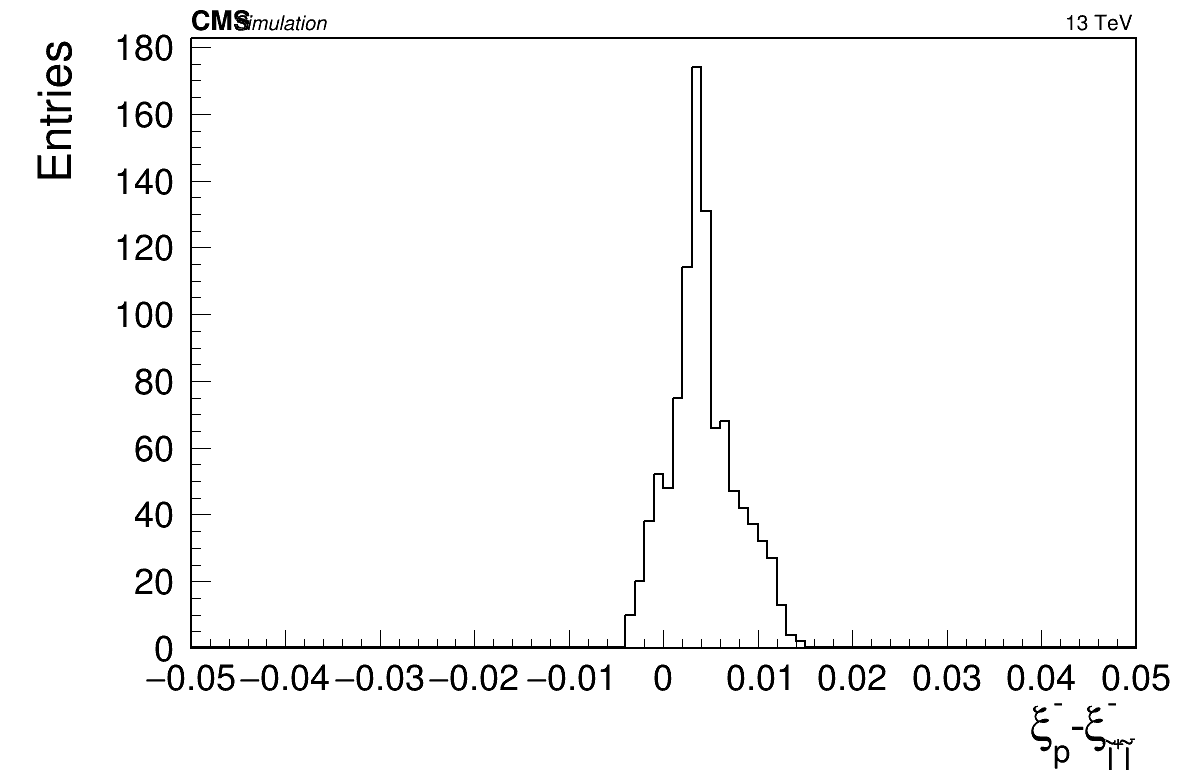

In [3]:
for smp in samples:
    if not smp.short:
        continue
    chunk_file = f'{CHUNKS_DIR}/{smp.short}.root'
    print(chunk_file)
    if not os.path.exists(chunk_file):
        continue
    rdf = PyRDF.RDataFrame("Events", chunk_file)

    # at this stage, we can either plot variables on a ROOT canvas, or export everything to a Pandas dataframe
    # using the RDataFrame NumPy export & Pandas NumPy import:
    #   df = pd.DataFrame(rdf.AsNumpy())
    # since I am a dinosaur, I prefer the ROOT option, but you may want to consider switching to this "new" method
    
    canv = ROOT.TCanvas("c2", "c2", 1200, 800)

    # like in the former stage, one can also define new variables using operations on the ones stored in the "chunks file"
    #rdf.Define('abs_prot_pz', 'TMath::Abs(prot_pz)').Histo1D('abs_prot_pz').Draw()
    rdf = rdf.Define('xip_diff', 'prot_xi[0]-slep_xi[0]') \
             .Define('xim_diff', 'prot_xi[1]-slep_xi[1]')
    #rdf.Histo1D(('xip_diff', ';#xi_{p}^{+}-#xi_{#tilde{l}^{+}#tilde{l}^{-}}^{+};Entries', 100, -0.05, 0.05), 'xip_diff').Draw('hist')
    rdf.Histo1D(('xim_diff', ';#xi_{p}^{-}-#xi_{#tilde{l}^{+}#tilde{l}^{-}}^{-};Entries', 100, -0.05, 0.05), 'xim_diff').Draw('hist')
    canv.Draw()
    canv.Update()
    CMS_lumi.CMS_lumi(canv.GetPad(0), 0, 0)